<a href="https://colab.research.google.com/github/daniel-mckemie/data71200_Su24_McKemie/blob/main/DMcKemie_DATA71200_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -U scikit-learn==1.4

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

GITHUB_REPO_URL = "https://raw.githubusercontent.com/daniel-mckemie/data71200_Su24_McKemie/main/"
CSV_FILE_NAME = "baseball.csv"

In [5]:
import pandas as pd
import urllib.request

def load_data_from_github(github_url=GITHUB_REPO_URL, csv_file=CSV_FILE_NAME):
    csv_url = github_url + csv_file
    try:
        # Download the CSV file to a local temporary file
        temp_file, _ = urllib.request.urlretrieve(csv_url)

        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(temp_file)

        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    finally:
        # Remove the temporary file to clean up
        if 'temp_file' in locals():
            os.remove(temp_file)


In [6]:
baseball_data = load_data_from_github()

if baseball_data is not None:
    print(baseball_data.head())

  Team League  Year   RS   RA   W    OBP    SLG     BA  Playoffs  RankSeason  \
0  ARI     NL  2012  734  688  81  0.328  0.418  0.259         0         NaN   
1  ATL     NL  2012  700  600  94  0.320  0.389  0.247         1         4.0   
2  BAL     AL  2012  712  705  93  0.311  0.417  0.247         1         5.0   
3  BOS     AL  2012  734  806  69  0.315  0.415  0.260         0         NaN   
4  CHC     NL  2012  613  759  61  0.302  0.378  0.240         0         NaN   

   RankPlayoffs    G   OOBP   OSLG  
0           NaN  162  0.317  0.415  
1           5.0  162  0.306  0.378  
2           4.0  162  0.315  0.403  
3           NaN  162  0.331  0.428  
4           NaN  162  0.335  0.424  


In [7]:
# Replace NaN values in RankSeason and RankPlayoffs with 0s
baseball_data['RankSeason'].fillna(0, inplace=True)
baseball_data['RankPlayoffs'].fillna(0, inplace=True)

In [8]:
# Drop the OOBP and OSLG columns
baseball_data.drop(columns=['OOBP', 'OSLG'], inplace=True)

In [9]:
# Create a new column OPS which is OBP + SLG
baseball_data['OPS'] = baseball_data['OBP'] + baseball_data['SLG']

In [11]:
from sklearn.model_selection import train_test_split

# Features around batting statistics.
features = ['RS', 'RA', 'OBP', 'SLG', 'BA', 'OPS']
X = baseball_data[features]

# To gauge success in making the Playoffs
y = baseball_data['Playoffs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV


# Define a function for evaluating models using classification metrics
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{model_name} Evaluation:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    return precision, recall, f1

# Define a function to run cross-validation and return the average scores for classification metrics
def cross_val_metrics(model, X, y):
    precision_scorer = make_scorer(precision_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')
    f1_scorer = make_scorer(f1_score, average='macro')

    precision_cv = cross_val_score(model, X, y, cv=5, scoring=precision_scorer).mean()
    recall_cv = cross_val_score(model, X, y, cv=5, scoring=recall_scorer).mean()
    f1_cv = cross_val_score(model, X, y, cv=5, scoring=f1_scorer).mean()

    print(f"Cross-Validation Metrics for {model.__class__.__name__}:")
    print(f"Precision (CV): {precision_cv:.2f}")
    print(f"Recall (CV): {recall_cv:.2f}")
    print(f"F1 Score (CV): {f1_cv:.2f}")

    return precision_cv, recall_cv, f1_cv

In [13]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression, using y = Wins (arguably a better variable to predict) required LinearRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

precision_lr, recall_lr, f1_lr = evaluate_model(y_test, y_pred_lr, "Logistic Regression")


Logistic Regression Evaluation:
Precision: 0.81
Recall: 0.77
F1 Score: 0.79


In [14]:
precision_lr_cv, recall_lr_cv, f1_lr_cv = cross_val_metrics(lr, X, y)

Cross-Validation Metrics for LogisticRegression:
Precision (CV): 0.83
Recall (CV): 0.78
F1 Score (CV): 0.80


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Similarly, using y = Wins, required RandomForestRegressor
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

precision_rf, recall_rf, f1_rf = evaluate_model(y_test, y_pred_rf, "Random Forest Classifier")

Random Forest Classifier Evaluation:
Precision: 0.79
Recall: 0.73
F1 Score: 0.76


In [17]:
precision_rf_cv, recall_rf_cv, f1_rf_cv = cross_val_metrics(rf, X, y)

Cross-Validation Metrics for RandomForestClassifier:
Precision (CV): 0.78
Recall (CV): 0.74
F1 Score (CV): 0.76


In [18]:
# Simple bar graphs to see results/params all in one place

def plot_evaluation_results(metrics, lr_metrics, rf_metrics, lr_cv_metrics, rf_cv_metrics):
    """
    Plot the evaluation metrics for Logistic Regression and Random Forest models.

    Parameters:
    metrics (list): List of metric names.
    lr_metrics (list): List of metric values for Logistic Regression.
    rf_metrics (list): List of metric values for Random Forest.
    lr_cv_metrics (list): List of cross-validation metric values for Logistic Regression.
    rf_cv_metrics (list): List of cross-validation metric values for Random Forest.
    """
    x = np.arange(len(metrics))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, lr_metrics, width, label='Logistic Regression')
    rects2 = ax.bar(x, rf_metrics, width, label='Random Forest')
    rects3 = ax.bar(x + width, lr_cv_metrics, width, label='Logistic Regression CV')
    rects4 = ax.bar(x + 2*width, rf_cv_metrics, width, label='Random Forest CV')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Model Evaluation Metrics')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Attach a text label above each bar in *rects*, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()

    plt.show()

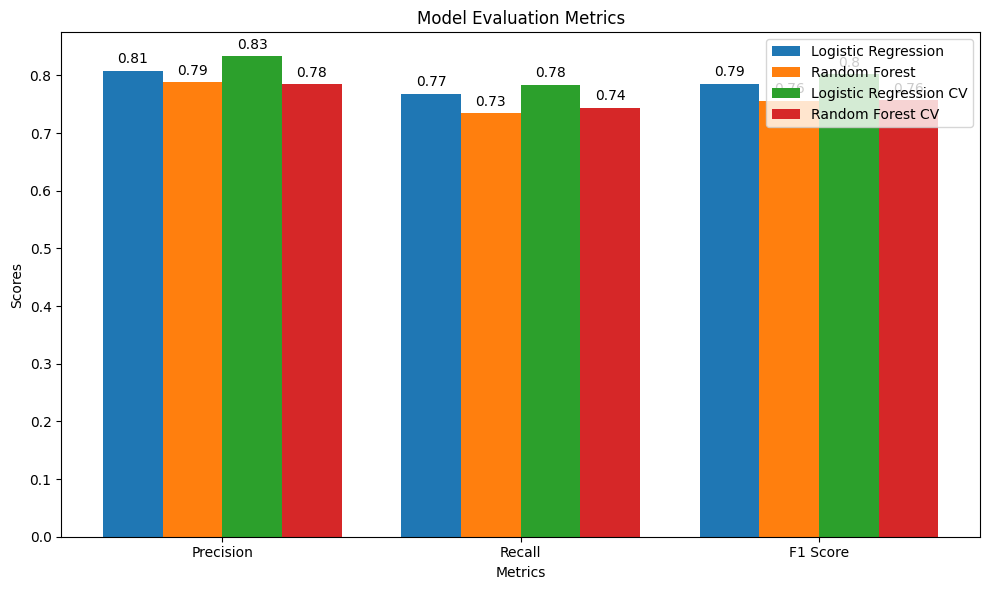

In [19]:
metrics = ['Precision', 'Recall', 'F1 Score']
lr_metrics = [precision_lr, recall_lr, f1_lr]
rf_metrics = [precision_rf, recall_rf, f1_rf]
lr_cv_metrics = [precision_lr_cv, recall_lr_cv, f1_lr_cv]
rf_cv_metrics = [precision_rf_cv, recall_rf_cv, f1_rf_cv]
plot_evaluation_results(metrics, lr_metrics, rf_metrics, lr_cv_metrics, rf_cv_metrics)


In [20]:
# Logistic Regression with Grid Search
lr = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both 'l1' and 'l2' penalties
}
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1_macro')
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [21]:
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

precision_lr, recall_lr, f1_lr = evaluate_model(y_test, y_pred_lr, "Logistic Regression")

Logistic Regression Evaluation:
Precision: 0.82
Recall: 0.78
F1 Score: 0.80


In [22]:
precision_lr_cv, recall_lr_cv, f1_lr_cv = cross_val_metrics(best_lr, X, y)

Cross-Validation Metrics for LogisticRegression:
Precision (CV): 0.83
Recall (CV): 0.78
F1 Score (CV): 0.80


In [29]:
# Random Forest Classifier with Grid Search, this takes a bit...
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1_macro')
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [33]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

precision_rf, recall_rf, f1_rf = evaluate_model(y_test, y_pred_rf, "Random Forest Classifier")

Random Forest Classifier Evaluation:
Precision: 0.82
Recall: 0.78
F1 Score: 0.80


In [34]:
precision_rf_cv, recall_rf_cv, f1_rf_cv = cross_val_metrics(best_rf, X, y)

Cross-Validation Metrics for RandomForestClassifier:
Precision (CV): 0.78
Recall (CV): 0.73
F1 Score (CV): 0.75


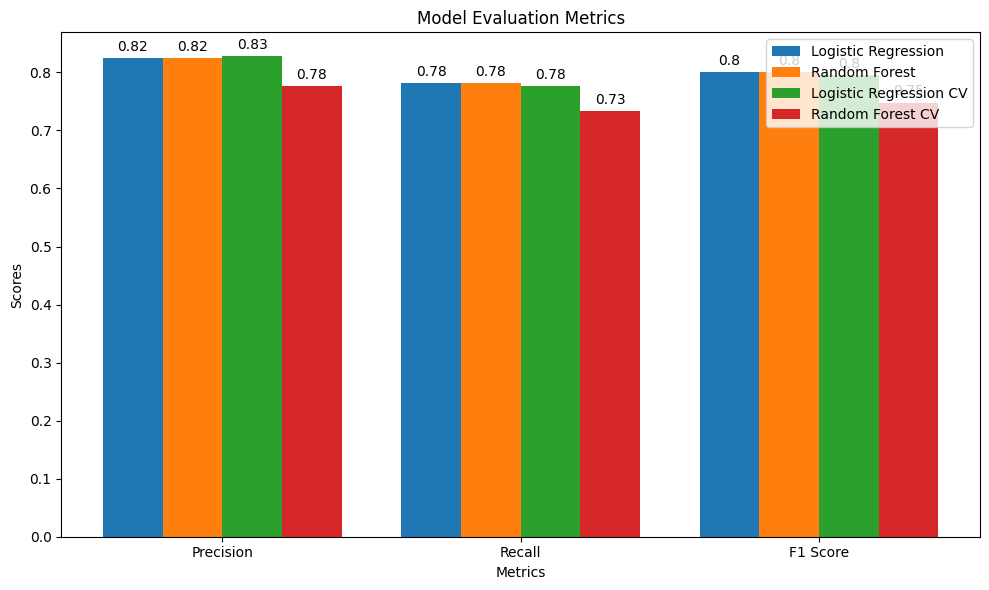

In [35]:
# Plot like above, with the best params

metrics = ['Precision', 'Recall', 'F1 Score']
lr_metrics = [precision_lr, recall_lr, f1_lr]
rf_metrics = [precision_rf, recall_rf, f1_rf]
lr_cv_metrics = [precision_lr_cv, recall_lr_cv, f1_lr_cv]
rf_cv_metrics = [precision_rf_cv, recall_rf_cv, f1_rf_cv]
plot_evaluation_results(metrics, lr_metrics, rf_metrics, lr_cv_metrics, rf_cv_metrics)